In [6]:
## Scraping College Football Major Conference Membership Data from Wikipedia

# Dependencies
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt



In [7]:
## New Block - Download and clean table of all FBS and FCS Teams
## directly from NCAA.com

## Division 1 - FCS (Football Championship Subdivision) URL - returns JSON
fcs_url = 'https://web3.ncaa.org/directory/api/directory/memberList?type=12&division=I-FCS&sportCode=MFB&_=1695167370986'

## Division 1 - FBS (Football Bowl Subdivision) URL
fbs_url = 'https://web3.ncaa.org/directory/api/directory/memberList?type=12&division=I-FBS&sportCode=MFB&_=1695166960182'

# get the FCS data
fcs_response = requests.get(fcs_url)
fcs_list = json.loads(fcs_response.text) # load the JSON
fcs_df = pd.DataFrame(fcs_list) # to dataframe

# get the FBS data
fbs_response = requests.get(fbs_url)
fbs_list = json.loads(fbs_response.text) # load the JSON
fbs_df = pd.DataFrame(fbs_list) # to dataframe

# Concatenate the FCS and FBS dataframes
ncaa_df = pd.concat([fcs_df, fbs_df], ignore_index=True)

# drop columns that have nan values
df = ncaa_df.dropna(axis=1, how='all')
# Extracting the 'state' key from the 'memberOrgAddress' column and creating a new column 'state'
df['state'] = df['memberOrgAddress'].apply(lambda x: x.get('state', None) if isinstance(x, dict) else None)

# Dropping the 'memberOrgAddress' column
df.drop('memberOrgAddress', axis=1, inplace=True)

## keep columns
keep_col = ['nameOfficial', 'division', 'subdivision', 'conferenceId', 'conferenceName', 
            'reclassYear',  'reclassDivision', 'reclassSubdivision',
            'privateFlag', 'historicallyBlackFlag', 'sportRegion', 'state']

# keep just the columns we want
df = df[keep_col]

rename_col = ['name', 'division', 'subdivision', 'conference_id', 'conference_name',
                'reclass_year', 'reclass_division', 'reclass_subdivision',
                'private', 'historically_black', 'region', 'state']
# remap the subdivision values 1 to FBS and 2 to FCS
df['subdivision'] = df['subdivision'].map({1: 'FBS', 2: 'FCS'})

# rename columns
df.columns = rename_col

df.head()

# save csv file
df.to_csv('../data/ncaa_com_fbs_fcs_table.csv', index=False)

C:\Users\Justin\AppData\Local\Temp\ipykernel_7440\2970117950.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['memberOrgAddress'].apply(lambda x: x.get('state', None) if isinstance(x, dict) else None)
C:\Users\Justin\AppData\Local\Temp\ipykernel_7440\2970117950.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('memberOrgAddress', axis=1, inplace=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_7440\2970117950.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [8]:
########## NEW BLOCK 9-15-23 ##########
### Use Wiki list of Division 1 FBS programs to get list of all conferences
### Extract all links from Former Conferences column and store in dataframe of conference, wiki_link

# URL of page to be scraped
url = 'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs'

# Retrieve page with the requests module
response = requests.get(url)

# Create BeautifulSoup object; parse with 'lxml'
soup = BeautifulSoup(response.text, 'lxml')
# extract Former Conferences column from table
table = soup.find('table', class_='wikitable sortable')

In [9]:
# create empty lists to store conference and wiki_link
conferences = []
wiki_links = []
rows = table.findAll('tr')

# Loop through the rows to extract data
for row in rows[1:]:  # Skip header row
    cells = row.findAll('td')
    
    if len(cells) > 6:  # Ensure there are enough columns to extract "Former Conferences"
        conf_cell = cells[6]
        
        # Find all the links within the "Former Conferences" cell
        links = conf_cell.findAll('a')
        
        # If there are links, extract conference name and link
        if links:
            for link in links:
                conferences.append(link.text)
                wiki_links.append(link.get('href'))
        else:
            # Extract plain text conferences without links
            conf_texts = conf_cell.get_text(separator="|").split('|')
            for conf in conf_texts:
                conferences.append(conf.strip())
                wiki_links.append(np.nan)

# Create a DataFrame
conf_df = pd.DataFrame({'conference': conferences, 'wiki_link': wiki_links})

# Convert the 'conference' column to string type
conf_df['conference'] = conf_df['conference'].astype(str)

# Now remove citation numbers from conference names
conf_df['conference'] = conf_df['conference'].str.replace(r"\[.*\]", "")

# Drop duplicates
conf_df.drop_duplicates(inplace=True)
# Drop any rows with NaN values in wiki_link column
conf_df.dropna(subset=['wiki_link'], inplace=True)
# Drop any rows with empty strings in conference column
conf_df = conf_df[conf_df['conference'] != '']
# sort alphabetically
conf_df.sort_values(by=['conference'], inplace=True)
# If the wiki_link coumn matches and existing row in the dataframe, drop it
conf_df.drop_duplicates(subset=['wiki_link'], keep='first', inplace=True)
# If the conference column matches and existing row in the dataframe, drop it
conf_df.drop_duplicates(subset=['conference'], keep='first', inplace=True)
# Display the first 20 rows of the dataframe
conf_df.tail(20)

len(conf_df)




C:\Users\Justin\AppData\Local\Temp\ipykernel_7440\919811544.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  conf_df['conference'] = conf_df['conference'].str.replace(r"\[.*\]", "")


65

In [10]:
conf_df.tail(40)
# conf_df.head(20)
# add the wiki link to the end of the wikipedia url
conf_df['wiki_link'] = 'https://en.wikipedia.org' + conf_df['wiki_link']

conf_df.head(20)


,conference,wiki_link
301,A-10,https://en.wikipedia.org/wiki/Atlantic_10_Conf...
147,ACC,https://en.wikipedia.org/wiki/Atlantic_Coast_C...
103,ASUN,https://en.wikipedia.org/wiki/ASUN_Conference
97,Alabama Intercollegiate/Collegiate,https://en.wikipedia.org/wiki/Southern_States_...
88,American,https://en.wikipedia.org/wiki/American_Athleti...
107,Atlantic 10,https://en.wikipedia.org/wiki/Atlantic_10_Conf...
8,BIAA,https://en.wikipedia.org/wiki/Border_Intercoll...
52,Big 12,https://en.wikipedia.org/wiki/Big_12_Conference
289,Big 4 Conference,https://en.wikipedia.org/wiki/Big_Four_Confere...
95,Big 8,https://en.wikipedia.org/wiki/Big_Eight_Confer...


In [11]:
## List of Current Conferences (2023) and their Wikipedia URLs
SEC = 'https://en.wikipedia.org/wiki/Southeastern_Conference'
ACC = 'https://en.wikipedia.org/wiki/Atlantic_Coast_Conference'
B1G = 'https://en.wikipedia.org/wiki/Big_Ten_Conference'
PAC12 = 'https://en.wikipedia.org/wiki/Pac-12_Conference'
BIG12 = 'https://en.wikipedia.org/wiki/Big_12_Conference'
AAC = 'https://en.wikipedia.org/wiki/American_Athletic_Conference'
MWC = 'https://en.wikipedia.org/wiki/Mountain_West_Conference'
MAC = 'https://en.wikipedia.org/wiki/Mid-American_Conference'
CUSA = 'https://en.wikipedia.org/wiki/Conference_USA'
SBC = 'https://en.wikipedia.org/wiki/Sun_Belt_Conference'


# Defunct Conferences That Have Been Major Conferences
SWC = 'https://en.wikipedia.org/wiki/Southwest_Conference'
BIG8 = 'https://en.wikipedia.org/wiki/Big_Eight_Conference'
BIGEAST = 'https://en.wikipedia.org/wiki/Big_East_Conference_(1979%E2%80%932013)'
IVY = 'https://en.wikipedia.org/wiki/Ivy_League'
PCC = 'https://en.wikipedia.org/wiki/Pacific_Coast_Conference'
BORDER = 'https://en.wikipedia.org/wiki/Border_Conference'
MVC = 'https://en.wikipedia.org/wiki/Missouri_Valley_Conference'
SKYLINE = 'https://en.wikipedia.org/wiki/Skyline_Conference_(1938%E2%80%931962)'
WAC = 'https://en.wikipedia.org/wiki/Western_Athletic_Conference_football'

# Create a dataframe of the above conferences and their wikipedia urls
existing_urls = pd.DataFrame({'conference': ['SEC', 'ACC', 'B1G', 'PAC12', 'BIG12', 'AAC', 'MWC', 'MAC', 'CUSA', 'SBC', 'SWC', 'BIG8', 'BIGEAST', 'IVY', 'PCC', 'BORDER', 'MVC', 'SKYLINE', 'WAC'],
                          'wiki_link': [SEC, ACC, B1G, PAC12, BIG12, AAC, MWC, MAC, CUSA, SBC, SWC, BIG8, BIGEAST, IVY, PCC, BORDER, MVC, SKYLINE, WAC]})

# add the conf_df to the existing_urls dataframe
conf_df = pd.concat([conf_df, existing_urls], ignore_index=True)

# drop any rows that are duplicates in the wiki_link column
conf_df.drop_duplicates(subset=['wiki_link'], keep='first', inplace=True)

# sort alphabetically
conf_df.sort_values(by=['conference'], inplace=True)

conf_df.head(15)

len(conf_df)






71

In [12]:
conf_df.tail(25)

# Save as csv for manual inspection
conf_df.to_csv('../TEMP/conference_wiki_links.csv', index=False)

In [8]:
## Put the URLs into a list and check them for status codes
urls = [SEC, ACC, B1G, PAC12, BIG12, AAC, MWC, MAC, CUSA, SBC, SWC, WAC, BIG8, BIGEAST, IVY, PCC, BORDER, MVC, SKYLINE, WAC]

# put the list of urls into a for loop to check the status code
for url in urls:
    response = requests.get(url)
    print(f"{url} status code: {response.status_code}")

https://en.wikipedia.org/wiki/Southeastern_Conference status code: 200
https://en.wikipedia.org/wiki/Atlantic_Coast_Conference status code: 200
https://en.wikipedia.org/wiki/Big_Ten_Conference status code: 200
https://en.wikipedia.org/wiki/Pac-12_Conference status code: 200
https://en.wikipedia.org/wiki/Big_12_Conference status code: 200
https://en.wikipedia.org/wiki/American_Athletic_Conference status code: 200
https://en.wikipedia.org/wiki/Mountain_West_Conference status code: 200
https://en.wikipedia.org/wiki/Mid-American_Conference status code: 200
https://en.wikipedia.org/wiki/Conference_USA status code: 200
https://en.wikipedia.org/wiki/Sun_Belt_Conference status code: 200
https://en.wikipedia.org/wiki/Southwest_Conference status code: 200
https://en.wikipedia.org/wiki/Western_Athletic_Conference_football status code: 200
https://en.wikipedia.org/wiki/Big_Eight_Conference status code: 200
https://en.wikipedia.org/wiki/Big_East_Conference_(1979%E2%80%932013) status code: 200
https

In [9]:
# MAC - Mid American Conference

# Use beautiful soup to parse the HTML and extract tables
response = requests.get(MAC)
soup = BeautifulSoup(response.text, 'html.parser')
tables = soup.find_all('table', class_='wikitable sortable')

# read tables into pandas
current = pd.read_html(str(tables[0]))[0]

# Manually create the former conference members dataframe
# Insitution, Location, Founded, Joined, Left, Nickname

# Create the empty dataframe
MAC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 
                            'Joined', 'Left', 'Enrollment', 'Conference'])

# New dataframe of former members
former = pd.DataFrame({'Institution': ['Butler University', 'University of Cincinnati', 'Marshall University', 'Marshall University', 'Wayne State University', 'Western Reserve University'],
                          'Location': ['Indianapolis, IN', 'Cincinnati, OH', 'Huntington, WV', 'Huntington, WV', 'Detroit, MI', 'Cleveland, OH'],
                            'Founded': [1855, 1819, 1837, 1837, 1868, 1826],
                            'Joined': [1946, 1946, 1954, 1997, 1946, 1946],
                            'Left': [1950, 1953, 1969, 2005, 1947, 1955],
                            'Nickname': ['Bulldogs', 'Bearcats', 'Thundering Herd', 'Thundering Herd', 'Tartars', 'Red Cats']})

# Clean the current members dataframe
# Rename the column headers
col_names = ['Institution', 'Location', 'Founded', 'Joined', 'Type', 'Enrollment',
             'Endowment', 'Nickname', 'Colors', 'drop']
current.columns = col_names
# Drop row with West Division in the Insitution column
current = current[current.Institution != 'West Division']
# Drop the Northern Illinois row that has errors - will recreate later
current = current[current.Institution != 'Northern Illinois University']

# Rename University at Buffalo to University of Buffalo
current.Institution = current.Institution.replace('University at Buffalo', 'University of Buffalo')

# Rename Miamai University to Miami (OH)
current.Institution = current.Institution.replace('Miami University', 'Miami (OH)')

# # Create new rows
new_row1 = {'Institution': 'Northern Illinois University', 'Location': 'DeKalb, IL', 'Founded': 1895, 'Joined': 1997, 'Type': 'Public', 'Enrollment': 19600, 'Endowment': 100000000, 'Nickname': 'Huskies', 'Colors': 'Cardinal and Black', 'drop': np.nan}
new_row2 = {'Institution': 'Northern Illinois University', 'Location': 'DeKalb, IL', 'Founded': 1895, 'Joined': 1975, 'Left': 1986, 'Type': 'Public', 'Enrollment': 19600, 'Endowment': 100000000, 'Nickname': 'Huskies', 'Colors': 'Cardinal and Black', 'drop': np.nan}
# add rows to the dataframe
former = former.append(new_row1, ignore_index=True)
former = former.append(new_row2, ignore_index=True)

# Combine the current and former dataframes into one
MAC = pd.concat([current, former], ignore_index=True)

# Add the conference column
MAC['Conference'] = 'Mid-American Conference'

# Keep only the columns we want
MAC = MAC[['Institution', 'Nickname', 'Location', 'Founded', 
           'Joined', 'Left', 'Enrollment', 'Conference']]

current 

former

# Save the dataframe to a csv file
MAC.to_csv('..\TEMP\conference_data\MAC.csv', index=False)

MAC
# Create dataframe of current members


C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1275234455.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  former = former.append(new_row1, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1275234455.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  former = former.append(new_row2, ignore_index=True)


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,University of Akron,Zips,"Akron, Ohio",1870,1992,NaN,16094,Mid-American Conference
1,Bowling Green State University,Falcons,"Bowling Green, Ohio",1910,1952,NaN,18142,Mid-American Conference
2,University of Buffalo,Bulls,"Buffalo, New York",1846,1998,NaN,32347,Mid-American Conference
3,Kent State University,Golden Flashes,"Kent, Ohio",1910,1951,NaN,26822,Mid-American Conference
4,Miami (OH),RedHawks,"Oxford, Ohio",1809,1947,NaN,18880,Mid-American Conference
5,Ohio University,Bobcats,"Athens, Ohio",1804,1946,NaN,25714,Mid-American Conference
6,Ball State University,Cardinals,"Muncie, Indiana",1918,1973,NaN,21597,Mid-American Conference
7,Central Michigan University,Chippewas,"Mount Pleasant, Michigan",1892,1971,NaN,17311,Mid-American Conference
8,Eastern Michigan University,Eagles,"Ypsilanti, Michigan",1849,1971,NaN,16294,Mid-American Conference
9,University of Toledo,Rockets,"Toledo, Ohio",1872,1950,NaN,18319,Mid-American Conference


In [10]:
## Working - Output aved in directory: conference_data


# Extract and clean SEC data
SEC_TABLES = pd.read_html(SEC)
current = SEC_TABLES[2]
future = SEC_TABLES[3].head()

# Drop Columns and standardized names
# Keep Institution, Nickname, Location, Founded, Joined, Enrollment

# Clean the current membership table

# Flatten multi-level headers
current.columns = [' '.join(col).strip() for col in current.columns.values]

# As a demo, we will now drop the columns that aren't part of the standardized dataframe
standard_columns = ['Institution East Division', 'Nickname East Division', 'Location East Division', 
                    'Founded East Division', 'Joined East Division']
current = current[standard_columns]

# Renaming for standardization
rename_map = {
    'Institution East Division': 'Institution',
    'Nickname East Division': 'Nickname',
    'Location East Division': 'Location',
    'Founded East Division': 'Founded',
    'Joined East Division': 'Joined',
    'Enrollment East Division': 'Enrollment'
}

# Rename columns
current = current.rename(columns=rename_map)

# keep_col = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Enrollment']
# current = current[keep_col]


keep_col_2 = ['Institution', 'Nickname', 'Location', 'Founded', 'Join Date', 'Enrollment']
future = future[keep_col_2]

# Rename Join Date to Joined
future = future.rename(columns={'Join Date': 'Joined'})

# Create empty stadard dataframe
SEC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 
                            'Joined', 'Left', 'Enrollment', 'Conference'])

# combine the two dataframes into the new standard dataframe
SEC = SEC.append(current)

# add the future dataframe to the standard dataframe
SEC = SEC.append(future)

# Drop the row that says West Division
SEC = SEC[SEC['Institution'] != 'West Division']

# Add SEC to the Conference Column
SEC['Conference'] = 'SEC'

# # Clean Enrollment Column
# SEC['Enrollment'] = SEC['Enrollment'].str.replace(',', '') # Remove commas
# SEC['Enrollment'] = SEC['Enrollment'].str.replace('\[.*\]', '') # Remove references

# # Fill na values with 0
# SEC['Enrollment'] = SEC['Enrollment'].fillna(0)
# # Store as integer
# SEC['Enrollment'] = SEC['Enrollment'].astype(int)


SEC.head(20)


# Save output to csv
SEC.to_csv('..\TEMP\conference_data\SEC.csv', index=False)



SEC


# # future.columns

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\4229421836.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SEC = SEC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\4229421836.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SEC = SEC.append(future)


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,University of Florida,Gators,"Gainesville, Florida",1853,1932,NaN,NaN,SEC
1,University of Georgia,Bulldogs,"Athens, Georgia",1785,1932,NaN,NaN,SEC
2,University of Kentucky,Wildcats,"Lexington, Kentucky",1865,1932,NaN,NaN,SEC
3,University of Missouri,Tigers,"Columbia, Missouri",1839,2012,NaN,NaN,SEC
4,University of South Carolina,Gamecocks,"Columbia, South Carolina",1801,1991,NaN,NaN,SEC
5,University of Tennessee,Volunteers,"Knoxville, Tennessee",1794,1932,NaN,NaN,SEC
6,Vanderbilt University,Commodores,"Nashville, Tennessee",1873,1932,NaN,NaN,SEC
8,University of Alabama,Crimson Tide,"Tuscaloosa, Alabama",1831,1932,NaN,NaN,SEC
9,University of Arkansas,Razorbacks,"Fayetteville, Arkansas",1871,1991,NaN,NaN,SEC
10,Auburn University,Tigers,"Auburn, Alabama",1856,1932,NaN,NaN,SEC


In [11]:
## Extract and Clean ACC Data

ACC_TABLES = pd.read_html(ACC)
current = ACC_TABLES[1]
future = ACC_TABLES[2] # Joining to Joined
former = ACC_TABLES[3] # 

# Rename future Joining to Joined
future = future.rename(columns={'Joining': 'Joined'})
# Remove citation numbers from Enrollment
future['Enrollment'] = future['Enrollment'].str.replace(r"\[.*\]", "")


# Clean up the Joined Column with regex to remove the citation numbers
current['Joined'] = current['Joined'].str.replace(r"\[.*\]", "")

# Drop Columns and standardized names 
# Standard Table:  Institution, Nickname, Location, Founded, Joined, Left, Enrollment, Conference
# Combine into single dataframe that includes current, future, and former

keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment']

ACC = pd.DataFrame(columns=keep_cols)

# Concatenate the three dataframes
ACC = ACC.append(current)
ACC = ACC.append(future)
ACC = ACC.append(former)

# Keep only the columns in list
ACC = ACC[keep_cols]

# Clean up Enrollment column
ACC['Enrollment'] = ACC['Enrollment'].str.replace(r"\[.*\]", "")
# Remove commas
ACC['Enrollment'] = ACC['Enrollment'].str.replace(',', '')
# Make sure it is numeric
ACC['Enrollment'] = pd.to_numeric(ACC['Enrollment'])
# Fill NaN with 0
ACC['Enrollment'] = ACC['Enrollment'].fillna(0)
# store as int
ACC['Enrollment'] = ACC['Enrollment'].astype(int)

# Rename Miami to Miami (FL)
ACC['Institution'] = ACC['Institution'].replace('University of Miami', 'Miami (FL)')
# Rename to Virginia Tech
ACC['Institution'] = ACC['Institution'].replace('Virginia Polytechnic Institute and State University', 'Virginia Tech')
# Rename Maryland to University of Maryland
ACC['Institution'] = ACC['Institution'].replace('University of Maryland, College Park', 'University of Maryland')
# Rename SOuthern Methodist University to SMU
ACC['Institution'] = ACC['Institution'].replace('Southern Methodist University', 'SMU')
# University of North Carolina at Chapel Hill to University of North Carolina
ACC['Institution'] = ACC['Institution'].replace('University of North Carolina at Chapel Hill', 'University of North Carolina')
# Georgia Institute of Technology to Georgia Tech
ACC['Institution'] = ACC['Institution'].replace('Georgia Institute of Technology', 'Georgia Tech')




# Add the Conference column
ACC['Conference'] = 'ACC'


## Save output to csv
ACC.to_csv('..\TEMP\conference_data\ACC.csv', index=False)
# ACC.info()

future
# current
# former

ACC

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\359751333.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  future['Enrollment'] = future['Enrollment'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\359751333.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Joined'] = current['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\359751333.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ACC = ACC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\359751333.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ACC = ACC.append(future)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\359751333.py:28: FutureWarni

,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,Clemson University,Tigers,"Clemson, South Carolina",1889,1953,NaN,25822,ACC
1,Duke University,Blue Devils,"Durham, North Carolina",1838,1953,NaN,16780,ACC
2,University of North Carolina,Tar Heels,"Chapel Hill, North Carolina",1789,1953,NaN,30101,ACC
3,North Carolina State University,Wolfpack,"Raleigh, North Carolina",1887,1953,NaN,36304,ACC
4,Wake Forest University,Demon Deacons,"Winston-Salem, North Carolina",1834,1953,NaN,8789,ACC
5,University of Virginia,Cavaliers,"Charlottesville, Virginia",1819,1953,NaN,25018,ACC
6,Georgia Tech,Yellow Jackets,"Atlanta, Georgia",1885,1979,NaN,36489,ACC
7,Florida State University,Seminoles,"Tallahassee, Florida",1851,1991,NaN,45493,ACC
8,Miami (FL),Hurricanes,"Coral Gables, Florida",1925,2004,NaN,17811,ACC
9,Virginia Tech,Hokies,"Blacksburg, Virginia",1872,2004,NaN,36383,ACC


In [12]:
# ACC

In [13]:
## BIG 12

BIG12_TABLES = pd.read_html(BIG12)

current = BIG12_TABLES[1]
future = BIG12_TABLES[2]
former = BIG12_TABLES[4]

# Remover citation numbers from Left column in former
former['Left'] = former['Left'].str.replace(r"\[.*\]", "")
# Remove citation numbers from Enrollment in all three
current['Enrollment'] = current['Enrollment'].str.replace(r"\[.*\]", "")
future['Enrollment'] = future['Enrollment'].str.replace(r"\[.*\]", "")
# former['Enrollment'] = former['Enrollment'].str.replace(r"\[.*\]", "")
# Assign a Joined date to future
future['Joined'] = '2024'

# Create a standard dataframe
BIG12 = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Concatenate the three dataframes
BIG12 = BIG12.append(current)
BIG12 = BIG12.append(future)
BIG12 = BIG12.append(former)

# Add the conference name to the Conference column
BIG12['Conference'] = 'Big 12'
# Save output to csv
BIG12.to_csv('..\TEMP\conference_data\BIG12.csv', index=False)

BIG12

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2078523093.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Left'] = former['Left'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2078523093.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Enrollment'] = current['Enrollment'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2078523093.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  future['Enrollment'] = future['Enrollment'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2078523093.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIG12 = BIG12.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2078523093.py:23:

,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference,Acronym,City,State,Type,Endowment(millions)[4],Mascot,Colors,Joining,Currentconference
0,Baylor University,Bears,NaN,1845,1996,NaN,"20,626",Big 12,BU,Waco,TX,Private(Baptist),"$1,970",Bruiser and Marigold,Green and Gold,NaN,NaN
1,Brigham Young University,Cougars,NaN,1875,2023,NaN,"34,390",Big 12,BYU,Provo,UT,Private(LDS),"$2,780[7]",Cosmo the Cougar,Blue and White,NaN,NaN
2,University of Central Florida,Knights,NaN,1963,2023,NaN,"71,948",Big 12,UCF,Orlando[a],FL,Public,$215,KnightroPegasus,Black and Gold,NaN,NaN
3,University of Cincinnati,Bearcats,NaN,1819,2023,NaN,"50,921",Big 12,UCCincy,Cincinnati,OH,Public,"$1,776[10]",The Bearcat,Red and Black,NaN,NaN
4,University of Houston,Cougars,NaN,1927,2023,NaN,"47,090",Big 12,UHUofH,Houston,TX,Public,"$1,004(System Wide)",Shasta,Scarlet Red and Albino White,NaN,NaN
5,Iowa State University,Cyclones,NaN,1858,1996,NaN,"30,708",Big 12,ISU,Ames,IA,Public,"$1,525",Cy the Cardinal,Cardinal and Gold,NaN,NaN
6,University of Kansas,Jayhawks,NaN,1865,1996,NaN,"27,638",Big 12,KU,Lawrence,KS,Public,"$2,731[14]",Big JayBaby Jay,Crimson and Blue,NaN,NaN
7,Kansas State University,Wildcats,NaN,1863,1996,NaN,"19,722",Big 12,KSUK-State,Manhattan,KS,Public,$952.3[16],Willie the Wildcat,Royal Purple and White,NaN,NaN
8,University of Oklahoma[b],Sooners,NaN,1890,1996,NaN,"28,052",Big 12,OU,Norman,OK,Public,"$1,640[20]",Sooner SchoonerBoomer and Sooner,Crimson and Cream,NaN,NaN
9,Oklahoma State University,Cowboys / Cowgirls,NaN,1890,1996,NaN,"24,660",Big 12,OSUOK State,Stillwater,OK,Public,"$1,544",Pistol Pete,Orange and Black,NaN,NaN


In [14]:
# Mountain West Conference


MWC_TABLES = pd.read_html(MWC)
current = MWC_TABLES[1]
former = MWC_TABLES[3]

# Create the Standard Dataframe
MWC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine the two dataframes into standard dataframe with the keep_cols
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

MWC = MWC.append(current)
MWC = MWC.append(former)
# Add conference name to Conference column
MWC['Conference'] = 'Mountain West Conference'
# keep only the columns in the keep_cols list
MWC = MWC[keep_cols]

# Save to csv
MWC.to_csv('..\TEMP\conference_data\MWC.csv', index=False)


MWC
# current
# # former

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1869347705.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MWC = MWC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1869347705.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MWC = MWC.append(former)


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,United States Air Force Academy,Falcons,"USAF Academy, Colorado[a]",1954,1999,NaN,4181,Mountain West Conference
1,Boise State University,Broncos,"Boise, Idaho",1932,2011,NaN,26155,Mountain West Conference
2,"California State University, Fresno",Bulldogs,"Fresno, California",1911,2012,NaN,25047,Mountain West Conference
3,Colorado State University,Rams,"Fort Collins, Colorado",1870,1999,NaN,27956,Mountain West Conference
4,"University of Nevada, Reno",Wolf Pack,"Reno, Nevada",1874,2012,NaN,21034,Mountain West Conference
5,"University of Nevada, Las Vegas",Rebels,"Las Vegas, Nevada[b]",1957,1999,NaN,30679,Mountain West Conference
6,University of New Mexico,Lobos,"Albuquerque, New Mexico",1889,1999,NaN,21738,Mountain West Conference
7,San Diego State University,Aztecs,"San Diego, California",1897,1999,NaN,35732,Mountain West Conference
8,San Jose State University,Spartans,"San Jose, California",1857,2013,NaN,35751,Mountain West Conference
9,Utah State University,Aggies,"Logan, Utah",1888,2013,NaN,27943,Mountain West Conference


In [15]:
# Conference USA

CUSA_TABLES = pd.read_html(CUSA)
current = CUSA_TABLES[1]
future = CUSA_TABLES[3] 
former = CUSA_TABLES[4]

# Create the Standard Dataframe
CUSA = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The three dataframes into the standard dataframe
CUSA = CUSA.append(current)
CUSA = CUSA.append(future)
CUSA = CUSA.append(former)

# Remove citation numbers from Joined and Left columns
CUSA['Joined'] = CUSA['Joined'].str.replace(r"\[.*\]", "")
CUSA['Enrollment'] = CUSA['Enrollment'].str.replace(r"\[.*\]", "")
# Remove commas
CUSA['Enrollment'] = CUSA['Enrollment'].str.replace(',', '')
# Fill NaN with 0
CUSA['Enrollment'] = CUSA['Enrollment'].fillna(0)
# store as int
CUSA['Enrollment'] = CUSA['Enrollment'].astype(int)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

CUSA = CUSA[keep_cols]

# Add conference name to Conference column
CUSA['Conference'] = 'Conference USA'

# Save to csv
CUSA.to_csv('..\TEMP\conference_data\CUSA.csv', index=False)

CUSA


# current
# former

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1336354616.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CUSA = CUSA.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1336354616.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CUSA = CUSA.append(future)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1336354616.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CUSA = CUSA.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1336354616.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  CUSA['Joined'] = CUSA['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1336354616.py:18: FutureWarning

,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,Florida International University,Panthers,"Miami, Florida[a]",1965,2013,NaN,58064,Conference USA
1,Jacksonville State University,Gamecocks,"Jacksonville, Alabama",1883,2023,NaN,9238,Conference USA
2,Liberty University,Flames & Lady Flames,"Lynchburg, Virginia",1971,2023,NaN,95148,Conference USA
3,Louisiana Tech University,Bulldogs & Lady Techsters,"Ruston, Louisiana",1894,2013,NaN,12467,Conference USA
4,Middle Tennessee State University,Blue Raiders,"Murfreesboro, Tennessee",1911,2013,NaN,21913,Conference USA
5,New Mexico State University,Aggies,"Las Cruces, New Mexico",1888,2023,NaN,21694,Conference USA
6,Sam Houston State University,Bearkats,"Huntsville, Texas",1879,2023,NaN,21679,Conference USA
7,University of Texas at El Paso,Miners,"El Paso, Texas",1914,2005,NaN,25151,Conference USA
8,Western Kentucky University,Hilltoppers & Lady Toppers,"Bowling Green, Kentucky",1906,2014,NaN,19456,Conference USA
0,Arkansas State University,Red Wolves,"Jonesboro, Arkansas",1909,2023,NaN,14109,Conference USA


In [16]:
# CUSA

In [17]:
## Sun Belt Conference

SBC_TABLES = pd.read_html(SBC)
current = SBC_TABLES[1]
future = SBC_TABLES[2]
former = SBC_TABLES[3]

# Create the Standard Dataframe
SBC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The three dataframes into the standard dataframe
SBC = SBC.append(current)
SBC = SBC.append(future)
SBC = SBC.append(former)

# Remove citation numbers from Joined and Left columns
# Make sure all columns are strings
SBC['Founded'] = SBC['Founded'].astype(str)
SBC['Joined'] = SBC['Joined'].astype(str)
SBC['Enrollment'] = SBC['Enrollment'].astype(str)
SBC['Joined'] = SBC['Joined'].str.replace(r"\[.*\]", "")
SBC['Enrollment'] = SBC['Enrollment'].str.replace(r"\[.*\]", "")
SBC['Left'] = SBC['Left'].str.replace(r"\[.*\]", "")

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

# Add conference name to Conference column
SBC['Conference'] = 'Sun Belt Conference'

# Drop the row that says Public
SBC = SBC[SBC['Institution'] != 'Public']

# Take care of nan values in the Joined column
# SBC['Joined'] = SBC['Joined'].fillna(0)

# Make sure Joined, Founded and left are an int
#Need to convert to float first to get rid of the decimal
SBC['Joined'] = SBC['Joined'].astype(float)
SBC['Joined'] = SBC['Joined'].fillna(0)
SBC['Joined'] = SBC['Joined'].astype(int)

SBC['Founded'] = SBC['Founded'].astype(float)
SBC['Founded'] = SBC['Founded'].fillna(0)
SBC['Founded'] = SBC['Founded'].astype(int)

SBC['Left'] = SBC['Left'].astype(float)
SBC['Left'] = SBC['Left'].fillna(0)
SBC['Left'] = SBC['Left'].astype(int)


# Save to csv
SBC.to_csv('..\TEMP\conference_data\SBC.csv', index=False)

# current
future
# former
SBC

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3992415750.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SBC = SBC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3992415750.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SBC = SBC.append(future)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3992415750.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SBC = SBC.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3992415750.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  SBC['Joined'] = SBC['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3992415750.py:22: FutureWarning: The de

,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference,Type,Endowment(millions),Colors,Sport,Primaryconference,Subsequentconference,Currentconference
0,Appalachian State University,Mountaineers,"Boone, North Carolina",1899,2014,0,"20,023",Sun Belt Conference,Public,$150[48],.mw-parser-output .legend{page-break-inside:av...,NaN,NaN,NaN,NaN
1,Arkansas State University,Red Wolves,"Jonesboro, Arkansas",1909,1991,0,"14,109",Sun Belt Conference,Public,$113,NaN,NaN,NaN,NaN,NaN
2,Coastal Carolina University,Chanticleers,"Conway, South Carolina",1954,2016,0,"10,894",Sun Belt Conference,Public,$54.7,NaN,NaN,NaN,NaN,NaN
3,Georgia Southern University,Eagles,"Statesboro, Georgia",1906,2014,0,"27,459",Sun Belt Conference,Public,$277.1,NaN,NaN,NaN,NaN,NaN
4,Georgia State University,Panthers,"Atlanta, Georgia",1913,1976,0,"53,619",Sun Belt Conference,Public,$179,NaN,NaN,NaN,NaN,NaN
5,James Madison University,Dukes,"Harrisonburg, Virginia",1908,2022,0,21496,Sun Belt Conference,Public,$154.7,NaN,NaN,NaN,NaN,NaN
6,University of Louisiana at Lafayette,Ragin' Cajuns,"Lafayette, Louisiana",1898,1991,0,"19,188",Sun Belt Conference,Public,$232,NaN,NaN,NaN,NaN,NaN
7,University of Louisiana at Monroe,Warhawks,"Monroe, Louisiana",1931,2006,0,"9,060",Sun Belt Conference,Public,$73,NaN,NaN,NaN,NaN,NaN
8,Marshall University,Thundering Herd,"Huntington, West Virginia",1837,2022,0,"11,962",Sun Belt Conference,Public,$192[56],NaN,NaN,NaN,NaN,NaN
9,Old Dominion University,Monarchs,"Norfolk, Virginia",1930,1982,0,"24,286",Sun Belt Conference,Public,$265.8[58],NaN,NaN,NaN,NaN,NaN


In [18]:
# Southwest Conference (Defunct)

SWC_TABLES = pd.read_html(SWC)
temp = SWC_TABLES[2]
final = SWC_TABLES[3]
# Rename Academic Year of Departure	to Left
final = final.rename(columns={'Academic Year of Departure': 'Left'})
temp = temp.rename(columns={'Academic Year of Departure': 'Left'})
# Remane Team to Institution
temp = temp.rename(columns={'Team': 'Institution'})
final = final.rename(columns={'Team': 'Institution'})

# make standard dataframe
SWC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine the two dataframes into the standard dataframe
SWC = SWC.append(temp)
SWC = SWC.append(final)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

SWC = SWC[keep_cols]

# Add conference name to Conference column
SWC['Conference'] = 'Southwest Conference'

# Manually add the Joined date to schools 
SWC.loc[SWC['Institution'] == 'Arkansas', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Baylor', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Houston', 'Joined'] = 1976
SWC.loc[SWC['Institution'] == 'Rice', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'SMU', 'Joined'] = 1918
SWC.loc[SWC['Institution'] == 'TCU', 'Joined'] = 1923
SWC.loc[SWC['Institution'] == 'Texas', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Texas A&M', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Texas Tech', 'Joined'] = 1956
SWC.loc[SWC['Institution'] == 'Southwestern', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Phillips', 'Joined'] = 1920
SWC.loc[SWC['Institution'] == 'Oklahoma', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Oklahoma A&M', 'Joined'] = 1915


# Save to csv
SWC.to_csv('..\TEMP\conference_data\SWC.csv', index=False)
SWC
# # temp

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1240182256.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SWC = SWC.append(temp)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1240182256.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SWC = SWC.append(final)


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,Oklahoma,NaN,NaN,NaN,1915,1919,NaN,Southwest Conference
1,Oklahoma A&M,NaN,NaN,NaN,1915,1925,NaN,Southwest Conference
2,Phillips,NaN,NaN,NaN,1920,1921,NaN,Southwest Conference
3,Southwestern,NaN,NaN,NaN,1915,1916,NaN,Southwest Conference
0,Arkansas,NaN,NaN,NaN,1915,1992,NaN,Southwest Conference
1,Texas A&M,NaN,NaN,NaN,1915,1996,NaN,Southwest Conference
2,Texas,NaN,NaN,NaN,1915,1996,NaN,Southwest Conference
3,Baylor,NaN,NaN,NaN,1915,1996,NaN,Southwest Conference
4,Texas Tech,NaN,NaN,NaN,1956,1996,NaN,Southwest Conference
5,Houston,NaN,NaN,NaN,1976,1996,NaN,Southwest Conference


In [19]:
# Western_Athletic_Conference

WAC_TABLES = pd.read_html(WAC)
current = WAC_TABLES[1]
former = WAC_TABLES[2]

# rename columns - First Year to Joined, Last Year to Left
current = current.rename(columns={'First Year': 'Joined', 'Last Year': 'Left'})

# Fix Team Name - Split them into Institution and Nickname

def split_team_name(team_name):
    words = team_name.split()
    
    # Rule 1: Two-word teams
    if len(words) == 2:
        return words[0], words[1]
    
    # Rule 2: Three-word teams with 'State'
    if len(words) == 3 and words[1] == 'State':
        return ' '.join(words[:2]), words[2]
    
    # Rule 3: Three-word teams without 'State'
    if len(words) == 3 and words[1] != 'State':
        return words[0], ' '.join(words[1:])
    
    # Rule 4: Four-word teams with 'New Mexico'
    if len(words) == 4 and ' '.join(words[:2]) == 'New Mexico':
        return ' '.join(words[:2]), ' '.join(words[2:])
    
    # Rule 5: Four-word teams
    if len(words) == 4:
        return ' '.join(words[:3]), words[3]
    
    # Rule 6: One-word teams
    if len(words) == 1:
        return team_name, ""  # manually fill in the nickname later

    return team_name, ""  # default fallback

# Apply the split_team_name function to the Team column
current[['Institution', 'Nickname']] = current['Team'].apply(split_team_name).apply(pd.Series)                   

# Create the Standard Dataframe
WAC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The three dataframes into the standard dataframe
WAC = WAC.append(current)
WAC = WAC.append(former)

## Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

WAC = WAC[keep_cols]

# Add conference name to Conference column
WAC['Conference'] = 'Western Athletic Conference'

# Manually clean the Same Houston State Nickname and Institution
WAC.loc[WAC['Institution'] == 'Sam', 'Nickname'] = 'Bearkats'
WAC.loc[WAC['Institution'] == 'Sam', 'Institution'] = 'Sam Houston State'
WAC.loc[WAC['Institution'] == 'Arizona State Sun', 'Institution'] = 'Arizona State'
WAC.loc[WAC['Institution'] == 'Arizona State', 'Nickname'] = 'Sun Devils'

# Manually clean the New Mexico State Nickname and Institution
WAC.loc[WAC['Institution'] == 'New Mexico', 'Nickname'] = 'Aggies'
WAC.loc[WAC['Institution'] == 'New Mexico', 'Institution'] = 'New Mexico State'

# manually clean the New Mexico Nickname and Institution
WAC.loc[WAC['Institution'] == 'New', 'Nickname'] = 'Lobos'
WAC.loc[WAC['Institution'] == 'New', 'Institution'] = 'New Mexico'

# Manually Fix Air Force
WAC.loc[WAC['Institution'] == 'Air', 'Nickname'] = 'Falcons'
WAC.loc[WAC['Institution'] == 'Air', 'Institution'] = 'Air Force'

# Save to csv
WAC.to_csv('..\TEMP\conference_data\WAC.csv', index=False)
current
WAC
# print(current['Team'].tolist())


C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1248258684.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WAC = WAC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1248258684.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WAC = WAC.append(former)


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,Air Force,Falcons,NaN,NaN,1980,1998,NaN,Western Athletic Conference
1,Arizona,Wildcats,NaN,NaN,1962,1977,NaN,Western Athletic Conference
2,Arizona State,Sun Devils,NaN,NaN,1962,1977,NaN,Western Athletic Conference
3,Boise State,Broncos,NaN,NaN,2001,2010,NaN,Western Athletic Conference
4,BYU,Cougars,NaN,NaN,1962,1998,NaN,Western Athletic Conference
5,Fresno State,Bulldogs,NaN,NaN,1992,2011,NaN,Western Athletic Conference
6,Colorado State,Rams,NaN,NaN,1967,1998,NaN,Western Athletic Conference
7,Hawaii,Warriors,NaN,NaN,1979,2011,NaN,Western Athletic Conference
8,Idaho,Vandals,NaN,NaN,2005,2012,NaN,Western Athletic Conference
9,Lamar,Cardinals,NaN,NaN,2021,2021,NaN,Western Athletic Conference


In [20]:
# Big 8 Conference - Defunct

BIG8_TABLES = pd.read_html(BIG8)

final = BIG8_TABLES[1]
other = BIG8_TABLES[2]

# Add 1996 to the Left column of the final dataframe
final['Left'] = 1996

# Joined and Left dates for the other dataframe
# Drake - Joined 1908, Left 1928
# Grinnell - Joined 1918, Left 1928
# University of Iowa - Joined 1907, Left 1911
# Washington University - Joined 1907, Left 1928

# Apply those dates to the other dataframe
other.loc[other['Institution'] == 'Drake University', 'Joined'] = 1908
other.loc[other['Institution'] == 'Drake University', 'Left'] = 1928
other.loc[other['Institution'] == 'Grinnell College', 'Joined'] = 1918
other.loc[other['Institution'] == 'Grinnell College', 'Left'] = 1928
other.loc[other['Institution'] == 'University of Iowa', 'Joined'] = 1907
other.loc[other['Institution'] == 'University of Iowa', 'Left'] = 1911
other.loc[other['Institution'] == 'Washington University in St. Louis', 'Joined'] = 1907
other.loc[other['Institution'] == 'Washington University in St. Louis', 'Left'] = 1928
other.loc[other['Institution'] == 'Washington University in St. Louis', 'Nickname'] = 'Bears'

# Make standard dataframe
BIG8 = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine the two dataframes into the standard dataframe
BIG8 = BIG8.append(final)
BIG8 = BIG8.append(other)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

BIG8 = BIG8[keep_cols]

# Add conference name to Conference column
BIG8['Conference'] = 'Big 8 Conference'

# Remove citation numbers from Enrollment. Make sure it is a string first
# Output a int
BIG8['Enrollment'] = BIG8['Enrollment'].astype(str)
BIG8['Enrollment'] = BIG8['Enrollment'].str.replace(r"\[.*\]", "")
# Remove commas
BIG8['Enrollment'] = BIG8['Enrollment'].str.replace(',', '')
BIG8['Enrollment'] = BIG8['Enrollment'].astype(int)


# Make sure Joined, Founded and Left are are int type
BIG8['Joined'] = BIG8['Joined'].astype(float)
BIG8['Joined'] = BIG8['Joined'].fillna(0)
BIG8['Joined'] = BIG8['Joined'].astype(int)

BIG8['Founded'] = BIG8['Founded'].astype(float)
BIG8['Founded'] = BIG8['Founded'].fillna(0)
BIG8['Founded'] = BIG8['Founded'].astype(int)

BIG8['Left'] = BIG8['Left'].astype(float)
BIG8['Left'] = BIG8['Left'].fillna(0)
BIG8['Left'] = BIG8['Left'].astype(int)

# Save to csv
BIG8.to_csv('..\TEMP\conference_data\BIG8.csv', index=False)

BIG8

# final
# other

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3246476320.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIG8 = BIG8.append(final)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3246476320.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIG8 = BIG8.append(other)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3246476320.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  BIG8['Enrollment'] = BIG8['Enrollment'].str.replace(r"\[.*\]", "")


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,University of Colorado,Buffaloes,"Boulder, Colorado",1876,1947,1996,30128,Big 8 Conference
1,Iowa State University,Cyclones,"Ames, Iowa",1858,1908,1996,28682,Big 8 Conference
2,University of Kansas,Jayhawks,"Lawrence, Kansas",1865,1907,1996,30004,Big 8 Conference
3,Kansas State University,Wildcats,"Manhattan, Kansas",1863,1913,1996,23588,Big 8 Conference
4,University of Missouri,Tigers,"Columbia, Missouri",1839,1907,1996,33318,Big 8 Conference
5,University of Nebraska,Cornhuskers,"Lincoln, Nebraska",1869,1907,1996,24100,Big 8 Conference
6,University of Oklahoma,Sooners,"Norman, Oklahoma",1890,1919,1996,29721,Big 8 Conference
7,Oklahoma State University,Cowboys,"Stillwater, Oklahoma",1890,1958,1996,23307,Big 8 Conference
0,Drake University,Bulldogs,"Des Moines, Iowa",1881,1908,1928,3164,Big 8 Conference
1,Grinnell College,Pioneers,"Grinnell, Iowa",1846,1918,1928,1688,Big 8 Conference


In [21]:
# Ivy League

IVY_TABLES = pd.read_html(IVY)
table1 = IVY_TABLES[1]
table2 = IVY_TABLES[2]

# Create the Standard Dataframe
IVY = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])


# Merge table on Institution
table1.merge(table2, on='Institution', how='outer')

# Rename columns - Undergraduates to Enrollment
table1 = table1.rename(columns={'Undergraduates': 'Enrollment'})
# Add Joined date - 1956 - offical incorporation of the Ivy League
table1['Joined'] = 1954
# Add Left date - 1981 - Ivy League Drops out of FBS Football
table1['Left'] = 1981

# Create the Standard Dataframe
IVY = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# add the table1 to the standard dataframe
IVY = IVY.append(table1)

# Save just the keep_cols
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

IVY = IVY[keep_cols]

# Add conference name to Conference column
IVY['Conference'] = 'Ivy League'

founded_list = [1642,1702,1747,1754,1755,1765,1768,1868]
IVY['Founded'] = founded_list

# Save to csv
IVY.to_csv('..\TEMP\conference_data\IVY.csv', index=False)

IVY
# table1
# # table2

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1123245674.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IVY = IVY.append(table1)


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,Brown University,Bears,"Providence, Rhode Island",1642,1954,1981,7349,Ivy League
1,Columbia University,Lions,"New York, New York",1702,1954,1981,"8,148[b]",Ivy League
2,Cornell University,Big Red,"Ithaca, New York",1747,1954,1981,15503,Ivy League
3,Dartmouth College,Big Green,"Hanover, New Hampshire",1754,1954,1981,4556,Ivy League
4,Harvard University,Crimson,"Cambridge, Massachusetts[c]",1755,1954,1981,7153,Ivy League
5,University of Pennsylvania,Quakers,"Philadelphia, Pennsylvania",1765,1954,1981,9962,Ivy League
6,Princeton University,Tigers,"Princeton, New Jersey",1768,1954,1981,5321,Ivy League
7,Yale University,Bulldogs,"New Haven, Connecticut",1868,1954,1981,6536,Ivy League


In [22]:
## Pacific Coast Conference

# University of California, Berkeley (1915–1959)
# University of Oregon (1915–1959)
# Oregon State College (1915–1959)
# University of Washington (1915–1959)
# Washington State College (1917–1959)
# Stanford University (1918–1959)
# University of Idaho (1922–1959)
# University of Southern California (1922–1959, suspended in 1924)
# University of Montana (1924–1950)
# University of California, Los Angeles (1928–1959)

#Create the Standard Dataframe
PCC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Add the schools to the dataframe
PCC.loc[0] = ['University of California, Berkeley', 'Golden Bears', 'Berkeley, California', 1868, 1915, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[1] = ['University of Oregon', 'Ducks', 'Eugene, Oregon', 1876, 1915, 1959, 22000, 'Pacific Coast Conference']
PCC.loc[2] = ['Oregon State College', 'Beavers', 'Corvallis, Oregon', 1868, 1915, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[3] = ['University of Washington', 'Huskies', 'Seattle, Washington', 1861, 1915, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[4] = ['Washington State College', 'Cougars', 'Pullman, Washington', 1890, 1917, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[5] = ['Stanford University', 'Cardinal', 'Stanford, California', 1891, 1918, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[6] = ['University of Idaho', 'Vandals', 'Moscow, Idaho', 1889, 1922, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[7] = ['University of Southern California', 'Trojans', 'Los Angeles, California', 1880, 1922, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[8] = ['University of Montana', 'Grizzlies', 'Missoula, Montana', 1893, 1924, 1950, 31000, 'Pacific Coast Conference']
PCC.loc[9] = ['University of California, Los Angeles', 'Bruins', 'Los Angeles, California', 1919, 1928, 1959, 31000, 'Pacific Coast Conference']

# Addd the Conference name to the Conference column
PCC['Conference'] = 'Pacific Coast Conference'

## Save to csv
PCC.to_csv('..\TEMP\conference_data\PCC.csv', index=False)

# PCC

In [23]:
## Border Conference

BORDER_TABLES = pd.read_html(BORDER)
table1 = BORDER_TABLES[1]
table2 = BORDER_TABLES[2]

# Create the Standard Dataframe
BORDER = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Add the data to the standard dataframe
BORDER = BORDER.append(table1)
BORDER = BORDER.append(table2)

# Clean the Joined Column of citation numbers
BORDER['Joined'] = BORDER['Joined'].str.replace(r"\[.*\]", "")
# Clean the Institution Column of citation numbers
BORDER['Institution'] = BORDER['Institution'].str.replace(r"\[.*\]", "")
# Overwrite Texas Tech University Left date with 1957
BORDER.loc[BORDER['Institution'] == 'Texas Tech University', 'Left'] = 1957



BORDER['Conference'] = 'Border Conference'

# Save to csv
BORDER.to_csv('..\TEMP\conference_data\BORDER.csv', index=False)

BORDER
# table1
# table2

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2993507139.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BORDER = BORDER.append(table1)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2993507139.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BORDER = BORDER.append(table2)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2993507139.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  BORDER['Joined'] = BORDER['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2993507139.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  BORDER['Institution'] = BORDER['Institution'].str.replace(r"\[.*\]", "")


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference,Affiliation,Subsequentconference(s),Currentconference(s),Type,Currentconference
0,University of Arizona,Wildcats,"Tucson, Arizona",1885,1931,1962,43625,Border Conference,Public,Western (WAC)(1962–78),Pacific-12 (Pac-12)(1978–present)(Big 12 in 20...,NaN,NaN
1,Arizona State University,Sun Devils,"Tempe, Arizona",1885,1931,1962,71946,Border Conference,Public,Western (WAC)(1962–78),Pacific-12 (Pac-12)(1978–present)(Big 12 in 20...,NaN,NaN
2,Hardin–Simmons University,Cowboys &Cowgirls,"Abilene, Texas",1891,1941,1962,2333,Border Conference,Baptist,D-III Independent(1962–90)Texas (TIAA)[b](1990...,American Southwest[b](1996–present),NaN,NaN
3,New Mexico State University,Aggies,"Las Cruces, New Mexico",1888,1931,1962,21694,Border Conference,Public,various[d],Conf. USA (C-USA)(2023–present),NaN,NaN
4,University of Texas at El Paso,Miners,"El Paso, Texas",1914,1935,1962,25151,Border Conference,Public,FBS Independent(1962–67)Western (WAC)(1967–2005),Conf. USA (C-USA)(2005–present),NaN,NaN
5,West Texas A&M University,Buffaloes,"Canyon, Texas",1910,1941,1962,10169,Border Conference,Public,various[h],Lone Star (LSC)[i](1986–91; 1993–present),NaN,NaN
0,Northern Arizona University,Lumberjacks,"Flagstaff, Arizona",1899,1931,1953,22791,Border Conference,NaN,New Mexico/Frontier(1953–62)NAIA Independent(1...,NaN,Public,Big Sky(1970–present)
1,University of New Mexico,Lobos,"Albuquerque, New Mexico",1889,1931,1951,25441,Border Conference,NaN,Skyline(1951–62)Western (WAC)(1962–99),NaN,Public,Mountain West (MWC)(1999–present)
2,Texas Tech University,Red Raiders,"Lubbock, Texas",1923,1932,1957,40666,Border Conference,NaN,Southwest (SWC)(1957–96),NaN,Public,Big 12(1996–present)


In [24]:
# Missouri Valley Conference

MVC_TABLES = pd.read_html(MVC)
current = MVC_TABLES[2] # Sows Current Memebers but it is no longer a Major Conference
former = MVC_TABLES[4]

# Clean up Institution Column
# Remove anything in brackets []
former['Institution'] = former['Institution'].str.replace(r"\[.*\]", "")
# Clean up Joined Column
# Remove anything in brackets []
former['Joined'] = former['Joined'].str.replace(r"\[.*\]", "")
# Clean Enrollment
# Remove anything in brackets []
former['Enrollment'] = former['Enrollment'].str.replace(r"\[.*\]", "")


# Create a row for each time a school has joined and left

# Remove old Creighton and Nebraska rows
former = former[former['Institution'] != 'Creighton University']
former = former[former['Institution'] != 'Nebraska']
# # Creighton University - Joined 1928, Left 1948, Joined 1977, Left 2013
# University of Nebraska - Joined 1907, Left 1919, Joined 1921, Left 1928

new_row1 = {'Institution': 'Creighton University', 'Nickname': 'Bluejays', 'Location': 'Omaha, Nebraska', 'Founded': 1878, 'Joined': 1928, 'Left': 1948, 'Enrollment': 8000, 'Conference': 'Missouri Valley Conference'}
new_row2 = {'Institution': 'Creighton University', 'Nickname': 'Bluejays', 'Location': 'Omaha, Nebraska', 'Founded': 1878, 'Joined': 1977, 'Left': 2013, 'Enrollment': 8000, 'Conference': 'Missouri Valley Conference'}
new_row3 = {'Institution': 'University of Nebraska', 'Nickname': 'Cornhuskers', 'Location': 'Lincoln, Nebraska', 'Founded': 1869, 'Joined': 1907, 'Left': 1919, 'Enrollment': 25000, 'Conference': 'Missouri Valley Conference'}
new_row4 = {'Institution': 'University of Nebraska', 'Nickname': 'Cornhuskers', 'Location': 'Lincoln, Nebraska', 'Founded': 1869, 'Joined': 1921, 'Left': 1928, 'Enrollment': 25000, 'Conference': 'Missouri Valley Conference'}

# Add the new rows to the dataframe
former = former.append(new_row1, ignore_index=True)
former = former.append(new_row2, ignore_index=True)
former = former.append(new_row3, ignore_index=True)
former = former.append(new_row4, ignore_index=True)


# Nebraska - Joined 1907, Left 1928
former.loc[former['Institution'] == 'Nebraska', 'Joined'] = 1907
former.loc[former['Institution'] == 'Nebraska', 'Left'] = 1928

# Creighton - Joined 1928, Left 1948
former.loc[former['Institution'] == 'Creighton', 'Joined'] = 1928
former.loc[former['Institution'] == 'Creighton', 'Left'] = 1948

# Create a new row for Creighton - Joined 1977, Left 2013 - Call it Creighton 2
Creighton_2 = former.loc[former['Institution'] == 'Creighton University 2']
# Add Joined and Left dates
Creighton_2['Joined'] = 1977
Creighton_2['Left'] = 2013
# Rename Creighton University 2 to Creighton
Creighton_2['Institution'] = 'Creighton'

# Add to the former dataframe
former = former.append(Creighton_2)



# Sort by Institution and Joined
MVC = former.sort_values(by=['Institution', 'Joined'])

# Add the Conference name to the Conference column
MVC['Conference'] = 'Missouri Valley Conference'

# Manually Remove the just the last instance of University of nebreska [index 13]
MVC = MVC.drop([13])




# Save to csv
MVC.to_csv('..\TEMP\conference_data\MVC.csv', index=False)

# table1 
MVC

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\4034462732.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Institution'] = former['Institution'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\4034462732.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Joined'] = former['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\4034462732.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Enrollment'] = former['Enrollment'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\4034462732.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  former = former.append(new_row1, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykerne

,Institution,Location,Founded,Joined,Left,Type,Enrollment,Nickname,Currentconference,Conference
0,Butler University,"Indianapolis, Indiana",1855,1932,1934,Private,4667,Bulldogs,Big East,Missouri Valley Conference
24,Creighton University,"Omaha, Nebraska",1878,1928,1948,NaN,8000,Bluejays,NaN,Missouri Valley Conference
25,Creighton University,"Omaha, Nebraska",1878,1977,2013,NaN,8000,Bluejays,NaN,Missouri Valley Conference
3,Grinnell College,"Grinnell, Iowa",1846,1918,1939,Private,1688,Pioneers,Midwest(NCAA Division III),Missouri Valley Conference
6,Iowa State College,"Ames, Iowa",1858,1907,1928,Public,29887,Cyclones,Big 12,Missouri Valley Conference
8,Kansas State College,"Manhattan, Kansas",1863,1913,1928,Public,23863,Wildcats,Big 12,Missouri Valley Conference
10,Loyola University Chicago,"Chicago, Illinois",1870,2013,2022,Private,"16,437",Ramblers,Atlantic 10,Missouri Valley Conference
11,Memphis State University,"Memphis, Tennessee",1912,1968,1973,Public,23031,Tigers,The American,Missouri Valley Conference
14,New Mexico State University,"Las Cruces, New Mexico",1888,1970,1983,Public,18497,Aggies,C-USA,Missouri Valley Conference
15,North Texas State University,"Denton, Texas",1890,1957,1975,Public,35694,Mean Green,The American,Missouri Valley Conference


In [25]:
## Skyline Conference

SKYLINE_TABLES = pd.read_html(SKYLINE)
final = SKYLINE_TABLES[1]
former = SKYLINE_TABLES[2]

# Clean up Joined and left columns - take first 4 digits
final['Joined'] = final['Joined'].str[:4]
final['Left'] = final['Left'].str[:4]
former['Joined'] = former['Joined'].str[:4]
former['Left'] = former['Left'].str[:4]


# Create the Standard Dataframe
SKYLINE = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The three dataframes into the standard dataframe
SKYLINE = SKYLINE.append(final)
SKYLINE = SKYLINE.append(former)

# Add Conference Name to Conference Column
SKYLINE['Conference'] = 'Skyline Conference'

# only keep the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

SKYLINE = SKYLINE[keep_cols]
# Add Conference Name to Conference Column
SKYLINE['Conference'] = 'Skyline Conference'

# Clean the Institution Column of citation numbers
SKYLINE['Institution'] = SKYLINE['Institution'].str.replace(r"\[.*\]", "")

# Clean the Nickname of University of Wyoming
SKYLINE.loc[SKYLINE['Institution'] == 'University of Wyoming', 'Nickname'] = 'Cowboys'

# Save to csv
SKYLINE.to_csv('..\TEMP\conference_data\SKYLINE.csv', index=False)


SKYLINE


# final
# former

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1554155812.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SKYLINE = SKYLINE.append(final)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1554155812.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SKYLINE = SKYLINE.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1554155812.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  SKYLINE['Institution'] = SKYLINE['Institution'].str.replace(r"\[.*\]", "")


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,Brigham Young University,Cougars,"Provo, Utah",1875,1937,1961,34100,Skyline Conference
1,Colorado State University,Rams,"Fort Collins, Colorado",1870,1937,1961,34166,Skyline Conference
2,University of Denver,Pioneers,"Denver, Colorado",1864,1937,1961,11952,Skyline Conference
3,University of Montana,Grizzlies,"Missoula, Montana",1893,1951,1961,10104,Skyline Conference
4,University of New Mexico,Lobos,"Albuquerque, New Mexico",1889,1951,1961,25441,Skyline Conference
5,University of Utah,Utes,"Salt Lake City, Utah",1850,1937,1961,33000,Skyline Conference
6,Utah State University,Aggies,"Logan, Utah",1888,1937,1961,27691,Skyline Conference
7,University of Wyoming,Cowboys,"Laramie, Wyoming",1886,1937,1961,12450,Skyline Conference
0,University of Colorado,Buffaloes,"Boulder, Colorado",1876,1937,1946,33246,Skyline Conference


In [26]:
## Big 10 Conference

# Can't use pandas to read the table because it is a multi-level header
# need to use beautiful soup to extract the table

# Create a function to extract the tables from the url
def extract_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')
    return tables

# Extract the tables from the url
tables = extract_table(B1G)

# Read them into pandas
current = pd.read_html(str(tables[1]))[0]
# Clean up table - remove extra header rows
current.columns = current.columns.droplevel(1)
# Drop Row that is West Division
current = current[current['Institution'] != 'West Division']
# current
# Add a Left coulumn
current['Left'] = ''

# Create two rows for Michigan to Reflect the two times they left the conference
# Drop the University of Michigan row
current = current[current['Institution'] != 'University of Michigan']
# Create the two new rows - first joined 1896, left 1907, second joined 1917, left never
row1 = {'Institution': 'University of Michigan', 'Nickname': 'Wolverines', 'Location': 'Ann Arbor, Michigan', 'Founded': 1817, 'Joined': 1896, 'Left': 1907, 'Enrollment': 45000, 'Conference': 'Big Ten Conference'}
row2 = {'Institution': 'University of Michigan', 'Nickname': 'Wolverines', 'Location': 'Ann Arbor, Michigan', 'Founded': 1817, 'Joined': 1917, 'Left': '', 'Enrollment': 45000, 'Conference': 'Big Ten Conference'}

# Add the two new rows
current = current.append(row1, ignore_index=True)
current = current.append(row2, ignore_index=True)


# Future Members
future = pd.read_html(str(tables[2]))[0]
# Rename Join Date to Joined
future = future.rename(columns={'Join Date': 'Joined'})

# Create the Standard Dataframe
B1G = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The two dataframes into the standard dataframe
B1G = B1G.append(current)
B1G = B1G.append(future)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

B1G = B1G[keep_cols]

# Add conference name to Conference column
B1G['Conference'] = 'Big Ten Conference'

# Fix Joined Manually
# Michigan State University - Joined 1950
# Indiana University - Joined 1899
# University of Iowa - Joined 1899
# Penn State University - Joined 1990

B1G.loc[B1G['Institution'] == 'Michigan State University', 'Joined'] = 1950
B1G.loc[B1G['Institution'] == 'Indiana University Bloomington', 'Joined'] = 1899
B1G.loc[B1G['Institution'] == 'University of Iowa', 'Joined'] = 1899
B1G.loc[B1G['Institution'] == 'Pennsylvania State University', 'Joined'] = 1990

# Clean Up Names in Institution column
replacements = {'University of Illinois Urbana–Champaign': 'Illinois',
                'Indiana University Bloomington': 'Indiana',
                'The Ohio State University': 'Ohio State',
                'Pennsylvania State University': 'Penn State',
                'Rutgers University–New Brunswick': 'Rutgers',
                'University of Minnesota, Twin Cities': 'Minnesota',
                'University of Nebraska–Lincoln': 'Nebraska',
                'University of Wisconsin–Madison': 'Wisconsin',
                'University of California, Los Angeles': 'UCLA',
                'University of Maryland, College Park': 'Maryland',
}

# Apply replacements to the Institution column
B1G['Institution'] = B1G['Institution'].replace(replacements)
                



# Save to csv
B1G.to_csv('..\TEMP\conference_data\B1G.csv', index=False)

B1G

# current
# future




C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2731990338.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current = current.append(row1, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2731990338.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current = current.append(row2, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2731990338.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  B1G = B1G.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\2731990338.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  B1G = B1G.append(future)


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,Indiana,Hoosiers,"Bloomington, Indiana",1820,1899,,42552,Big Ten Conference
1,Maryland,Terrapins,"College Park, Maryland",1856,2014,,40709,Big Ten Conference
2,Michigan State University,Spartans,"East Lansing, Michigan",1855,1950,,49695,Big Ten Conference
3,Ohio State University,Buckeyes,"Columbus, Ohio",1870,1912,,61369,Big Ten Conference
4,Penn State,Nittany Lions,"University Park, Pennsylvania",1855,1990,,45901,Big Ten Conference
5,Rutgers,Scarlet Knights,"New Brunswick–Piscataway, New Jersey",1766,2014,,50411,Big Ten Conference
6,Illinois,Fighting Illini,"Urbana-Champaign, Illinois[e]",1867,1896,,52331,Big Ten Conference
7,University of Iowa,Hawkeyes,"Iowa City, Iowa",1847,1899,,30448,Big Ten Conference
8,Minnesota,Golden Gophers,"Minneapolis-St. Paul, Minnesota",1851,1896,,52017,Big Ten Conference
9,Nebraska,Cornhuskers,"Lincoln, Nebraska",1869,2011,,25057,Big Ten Conference


In [27]:
## Pac 12 Conference

# Can't use pandas to read the table because it is a multi-level header
# need to use beautiful soup to extract the table

# Create a function to extract the tables from the url
def extract_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')
    return tables

# Extract the tables from the url
tables = extract_table(PAC12)

# Read them into pandas
current = pd.read_html(str(tables[1]))[0]

# Remove citations from Enrollment
current['Enrollment'] = current['Enrollment'].str.replace(r"\[.*\]", "")

# Change any Joined date that are before 1959 to 1959
current.loc[current['Joined'] < 1959, 'Joined'] = 1959

# Add Left 2023 to all current members
current['Left'] = 2023

# Create the Standard Dataframe
PAC12 = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Add the data to the standard dataframe
PAC12 = PAC12.append(current)

# keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

PAC12 = PAC12[keep_cols]

# Add conference name to Conference column
PAC12['Conference'] = 'Pac-12 Conference'

# Clean enrollment column of citations and commas - store as int
PAC12['Enrollment'] = PAC12['Enrollment'].str.replace(r"\[.*\]", "")
PAC12['Enrollment'] = PAC12['Enrollment'].str.replace(',', '')
## Fill and nan values with 0
PAC12['Enrollment'] = PAC12['Enrollment'].fillna(0)
# store as int
PAC12['Enrollment'] = PAC12['Enrollment'].astype(int)

# Save to csv
PAC12.to_csv('..\TEMP\conference_data\PAC12.csv', index=False)

PAC12

# current
former

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1866393722.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Enrollment'] = current['Enrollment'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1866393722.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PAC12 = PAC12.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1866393722.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  PAC12['Enrollment'] = PAC12['Enrollment'].str.replace(r"\[.*\]", "")


,Institution,Location,Founded,Type,Enrollment,Joined,Left,Nickname,Subsequentconference(s),Currentconference(s)
0,University of Colorado,"Boulder, Colorado",1876,Public,33246,1937,1946,Buffaloes,Big 8(1947–48 to 1995–96)Big 12(1996–97 to 201...,Pac-12(2011–12 to present)


In [28]:
## American Athletic Conference

# Use beautiful soup to extract the table

# Create a function to extract the tables from the url
def extract_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')
    return tables

# Extract the tables from the url
tables = extract_table(AAC)

# read them into pandas
current = pd.read_html(str(tables[2]))[0]
former = pd.read_html(str(tables[4]))[0]

# Remove citation numbers from Founded in current
current['Founded'] = current['Founded'].str.replace(r"\[.*\]", "")

# Create the Standard Dataframe
AAC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The two dataframes into the standard dataframe
AAC = AAC.append(current)
AAC = AAC.append(former)

AAC['Conference'] = 'American Athletic Conference'

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

AAC = AAC[keep_cols]

# Remover citation numbers from Enrollment
AAC['Enrollment'] = AAC['Enrollment'].str.replace(r"\[.*\]", "")
# Remove commas
AAC['Enrollment'] = AAC['Enrollment'].str.replace(',', '')
# Fill in nan values with 0
AAC['Enrollment'] = AAC['Enrollment'].fillna(0)
# Convert to int
AAC['Enrollment'] = AAC['Enrollment'].astype(int)

# Clean UAB name
AAC.loc[AAC['Institution'] == 'University of Alabama at Birmingham', 'Institution'] = 'UAB'

# Save to csv
AAC.to_csv('..\TEMP\conference_data\AAC.csv', index=False)


AAC


# current
# former

# AAC

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3159403216.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Founded'] = current['Founded'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3159403216.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AAC = AAC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3159403216.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AAC = AAC.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\3159403216.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  AAC['Enrollment'] = AAC['Enrollment'].str.replace(r"\[.*\]", "")


,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,UAB,Blazers,"Birmingham, Alabama",1969,2023,NaN,21923,American Athletic Conference
1,East Carolina University,Pirates,"Greenville, North Carolina",1907,2014,NaN,28028,American Athletic Conference
2,Florida Atlantic University,Owls,"Boca Raton, Florida",1961,2023,NaN,30171,American Athletic Conference
3,University of Memphis,Tigers,"Memphis, Tennessee",1912,2013,NaN,21458,American Athletic Conference
4,University of North Carolina at Charlotte,49ers,"Charlotte, North Carolina",1946,2023,NaN,30146,American Athletic Conference
5,University of North Texas,Mean Green,"Denton, Texas",1890,2023,NaN,42375,American Athletic Conference
6,Rice University,Owls,"Houston, Texas",1912,2023,NaN,7124,American Athletic Conference
7,University of South Florida,Bulls,"Tampa, Florida",1956,2013,NaN,50830,American Athletic Conference
8,Southern Methodist University,Mustangs,"University Park, Texas",1911,2013,NaN,11649,American Athletic Conference
9,Temple University,Owls,"Philadelphia, Pennsylvania",1884,2013,NaN,37365,American Athletic Conference


In [29]:
## Big East Conference

# Use beautiful soup to extract the table

# Create a function to extract the tables from the url
def extract_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')
    return tables

# Extract the tables from the url
tables = extract_table(BIGEAST)

# Read the tables into pandas
current = pd.read_html(str(tables[3]))[0]

former = pd.read_html(str(tables[6]))[0]
# Rename Location(Population) to Location and remover the numbers in parenthesis
former = former.rename(columns={'Location(Population)': 'Location'})
former['Location'] = former['Location'].str.replace(r"\(.*\)", "")
current = current.rename(columns={'Location(Population)': 'Location'})
current['Location'] = current['Location'].str.replace(r"\(.*\)", "")

# Rename Beggining Year to Joined and Ending Year to Left
former = former.rename(columns={'Beginning Year': 'Joined', 'Ending Year': 'Left'})

# Rename YearJoined to Joined
current = current.rename(columns={'YearJoined': 'Joined'})

# Create the Standard Dataframe
BIGEAST = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The two dataframes into the standard dataframe
BIGEAST = BIGEAST.append(current)
BIGEAST = BIGEAST.append(former)

# Rename Miami to Miami (FL)
BIGEAST.loc[BIGEAST['Institution'] == 'University of Miami', 'Institution'] = 'Miami (FL)'

# Add Conference Name to Conference Column
BIGEAST['Conference'] = 'Big East Conference'

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

BIGEAST = BIGEAST[keep_cols]

# Remover citation numbers from Institution
BIGEAST['Institution'] = BIGEAST['Institution'].str.replace(r"\[.*\]", "")

# If the Left column is empty then fill it with 2013
BIGEAST['Left'] = BIGEAST['Left'].fillna(2013)

# Save to csv
BIGEAST.to_csv('..\TEMP\conference_data\BIGEAST.csv', index=False)

BIGEAST

# current
# former


C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1865617566.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Location'] = former['Location'].str.replace(r"\(.*\)", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1865617566.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Location'] = current['Location'].str.replace(r"\(.*\)", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1865617566.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIGEAST = BIGEAST.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1865617566.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIGEAST = BIGEAST.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\18656175

,Institution,Nickname,Location,Founded,Joined,Left,Enrollment,Conference
0,University of Cincinnati,Bearcats,Cincinnati,1819,2005,2013,41357,Big East Conference
1,University of Connecticut,Huskies,"Storrs, Connecticut",1881,1979,2013,30034,Big East Conference
2,University of Louisville,Cardinals,"Louisville, Kentucky",1798,2005,2013,23262,Big East Conference
3,University of Pittsburgh,Panthers,"Pittsburgh, Pennsylvania",1787,1982,2013,28823,Big East Conference
4,Rutgers University,Scarlet Knights,"New Brunswick, New Jersey",1766,1995,2013,38912,Big East Conference
5,University of South Florida,Bulls,"Tampa, Florida",1956,2005,2013,47122,Big East Conference
6,Syracuse University,Orange,"Syracuse, New York",1870,1979,2013,20407,Big East Conference
7,West Virginia University **,Mountaineers,"Morgantown, West Virginia",1867,1995,2013,29660,Big East Conference
0,Boston College,Eagles,"Chestnut Hill, Massachusetts",NaN,1979,2005,NaN,Big East Conference
1,Miami (FL),Hurricanes,"Coral Gables, Florida",NaN,1991,2004,NaN,Big East Conference


In [30]:
## Create a master file from all of the individual conference files

# Create a list of all the conference files
import os

# Create a list of all the conference files
conference_files = os.listdir('..\TEMP\conference_data')
# conference_files

# Create a dataframe to hold all of the conference data
master_df = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Loop through the conference files and append them to the master dataframe
for file in conference_files:
    temp_df = pd.read_csv('..\TEMP\conference_data\\' + file)
    master_df = master_df.append(temp_df)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']
master_df = master_df[keep_cols]

# Clean up the Institution column
master_df['Institution'] = master_df['Institution'].str.replace('University of ', '') # remove University of
master_df['Institution'] = master_df['Institution'].str.replace('University', '') # remove University
master_df['Institution'] = master_df['Institution'].str.replace('College of', '') # remove College of
master_df['Institution'] = master_df['Institution'].str.replace('College', '') # remove College
# remove citation numbers
master_df['Institution'] = master_df['Institution'].str.replace(r"\[.*\]", "")
# Strip whitespace
master_df['Institution'] = master_df['Institution'].str.strip()

##############################
# Adjustments to Institution column
###################################
# Boston to Boston College to match the other files
master_df.loc[master_df['Institution'] == 'Boston', 'Institution'] = 'Boston College'
# Bowling Green State to Bowling Green
master_df.loc[master_df['Institution'] == 'Bowling Green State', 'Institution'] = 'Bowling Green'
# Middle Tennessee State to Middle Tennessee
master_df.loc[master_df['Institution'] == 'Middle Tennessee State', 'Institution'] = 'Middle Tennessee'
# Lousiana at Monroe to Louisiana-Monroe
master_df.loc[master_df['Institution'] == 'Louisiana at Monroe', 'Institution'] = 'Louisiana-Monroe'
# California, Berkley to California
master_df.loc[master_df['Institution'] == 'California, Berkeley', 'Institution'] = 'California'
# Southern Mississippi to Southern Miss
master_df.loc[master_df['Institution'] == 'Southern Mississippi', 'Institution'] = 'Southern Miss'
# Central Forida (UCF) to UCF
master_df.loc[master_df['Institution'] == 'Central Florida (UCF)', 'Institution'] = 'UCF'
# North Carolina at Charlotte to Charlotte
master_df.loc[master_df['Institution'] == 'North Carolina at Charlotte', 'Institution'] = 'Charlotte'
# Louisiana State to LSU
master_df.loc[master_df['Institution'] == 'Louisiana State', 'Institution'] = 'LSU'
# Texas at San Antonio	 to UTSA
master_df.loc[master_df['Institution'] == 'Texas at San Antonio', 'Institution'] = 'UTSA'
# Nevada, Las Vegas	to UNLV
master_df.loc[master_df['Institution'] == 'Nevada, Las Vegas', 'Institution'] = 'UNLV'
# Colorado, Boulder
master_df.loc[master_df['Institution'] == 'Colorado, Boulder', 'Institution'] = 'Colorado'
# California, Los Angeles	to UCLA
master_df.loc[master_df['Institution'] == 'California, Los Angeles', 'Institution'] = 'UCLA'
# Mississippi to Ole Miss
master_df.loc[master_df['Institution'] == 'Mississippi', 'Institution'] = 'Ole Miss'
# North Carolina State	to NC State
master_df.loc[master_df['Institution'] == 'North Carolina State', 'Institution'] = 'NC State'
# Jacksonville to Jacksonville State
master_df.loc[master_df['Institution'] == 'Jacksonville', 'Institution'] = 'Jacksonville State'
# Brigham Young	 to BYU
master_df.loc[master_df['Institution'] == 'Brigham Young', 'Institution'] = 'BYU'










# Drop rows with empty values in Institution
master_df = master_df.dropna(subset=['Institution'])

# Save the master dataframe to a csv
master_df.to_csv('..\data\cfb_conference_members.csv', index=False)

C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1305154112.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1305154112.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1305154112.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Temp\ipykernel_17924\1305154112.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Te

In [31]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 27
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Institution  358 non-null    object
 1   Nickname     345 non-null    object
 2   Location     295 non-null    object
 3   Founded      314 non-null    object
 4   Joined       358 non-null    object
 5   Left         229 non-null    object
 6   Enrollment   270 non-null    object
 7   Conference   358 non-null    object
dtypes: object(8)
memory usage: 25.2+ KB


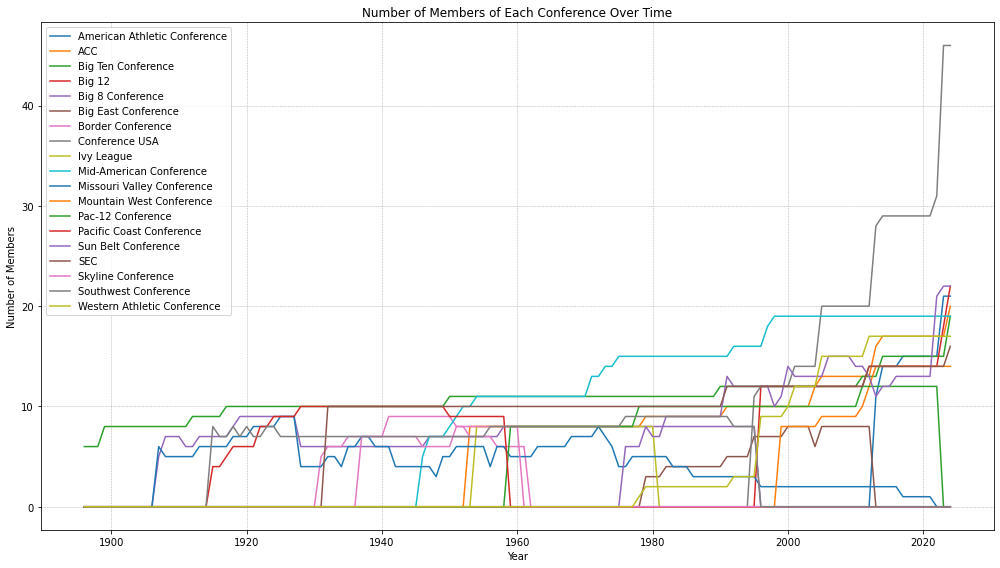

In [32]:
# Reload the data
cfb_data = master_df

# Convert 'Joined' and 'Left' columns to datetime format
cfb_data['Joined'] = pd.to_datetime(cfb_data['Joined'], format='%Y', errors='coerce')
cfb_data['Left'] = pd.to_datetime(cfb_data['Left'], format='%Y', errors='coerce')

# Recreate the yearly membership dataframe
start_year = cfb_data['Joined'].min().year
end_year = cfb_data['Joined'].max().year
data_dict = {}
for year in range(start_year, end_year + 1):
    yearly_data = {}
    for conference in cfb_data['Conference'].unique():
        members = cfb_data[(cfb_data['Conference'] == conference) & 
                           (cfb_data['Joined'].dt.year <= year) & 
                           ((cfb_data['Left'].isnull()) | (cfb_data['Left'].dt.year > year))]['Institution'].tolist()
        yearly_data[conference] = members
    data_dict[year] = yearly_data
yearly_members_df_corrected = pd.DataFrame.from_dict(data_dict, orient='index')

# Compute the number of members for each conference over the years
membership_counts = yearly_members_df_corrected.applymap(len)

# Plotting the membership counts over time
plt.figure(figsize=(14, 8))
for column in membership_counts.columns:
    plt.plot(membership_counts.index, membership_counts[column], label=column, marker='', linewidth=1.5)

# Adding legend, labels and title
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of Members')
plt.title('Number of Members of Each Conference Over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()


In [33]:
# Save as csv
yearly_members_df_corrected.to_csv('..\data\yearly_conference_members.csv', index=True)

In [34]:
# ## extract tables with pandas
# SEC_tables = pd.read_html(SEC)
# ACC_tables = pd.read_html(ACC)
# # B1G_tables = pd.read_html(B1G)
# # PAC12_tables = pd.read_html(PAC12)
# BIG12_tables = pd.read_html(BIG12)
# # AAC_tables = pd.read_html(AAC)
# MWC_tables = pd.read_html(MWC)
# MAC_tables = pd.read_html(MAC)
# CUSA_tables = pd.read_html(CUSA)
# SBC_tables = pd.read_html(SBC)

# SWC_tables = pd.read_html(SWC)
# WAC_tables = pd.read_html(WAC)
# BIG8_tables = pd.read_html(BIG8)
# # BIGEAST_tables = pd.read_html(BIGEAST)
# IVY_tables = pd.read_html(IVY)
# PCC_tables = pd.read_html(PCC)
# BORDER_tables = pd.read_html(BORDER)
# MVC_tables = pd.read_html(MVC)
# SKYLINE_tables = pd.read_html(SKYLINE)


In [35]:
## Extract all the tables that list "Current Members" and "Former Members" from each conference's Wikipedia page
## Store the tables in a list

# tables = []

# for url in urls:
#     response = requests.get(url)
#     soup = BeautifulSoup(response.text, 'html.parser')
#     tables.append(soup.find_all('table', class_='wikitable'))

# ## Create a list of the current members of each conference
## Create a list of the former members of each conference
